In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

In [2]:
dataset_name = 'nicaragua'
out_path = '../../data/frequencies/nicaragua'
tree_path = '../../data/frequencies/nicaragua/nicaragua_tree.json'
freqs_path = '../../data/frequencies/nicaragua/nicaragua_frequencies.json'
reference_path = '../../data/reference_seqs/genotype_refs_pyke2016.csv'
titer_path = '../../data/katzelnick2015/processed/genotypes_normalized.csv'

In [3]:
def assign_genotype_attr(tree, mrcas):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in ['genotype', 'genotype_mrca', 'clade_name']}
        
    for genotype, node in mrcas.items():
        node.traits['genotype_mrca'] = True
        node.traits['genotype'] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if 'genotype' in child.traits:
                if genotype != child.traits['genotype']:
                    print 'ERROR: Overlapping genotypes %s and %s at index %s'%(child.traits['genotype'], genotype, child.index)
            child.traits['genotype'] = genotype
    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

def load_all_frequencies(mrcas, path=freqs_path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, all_frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for region in all_frequencies.keys():
        for genotype, mrca in mrcas.items():
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[region][genotype] = all_frequencies[region][mrca_clade] 
    return dict(genotype_frequencies)

def make_dataframes(regions, genotype_frequencies, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    region_dfs = {}
    for region in regions:
        region_data = frequencies[region]
        df = pd.DataFrame(region_data, index=pivots)
        df = df.loc[df.index[df.index >= mindate]]
        region_dfs[region] = df
    return region_dfs

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = { gt: tree.commonAncestor(tips, numName=True) for gt, tips in genotype_refs.items() }
    return genotype_mrcas

In [4]:
tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']
tree = annotate_references(tree)

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

tmp = load_all_frequencies(mrcas)

# {'south_america': 
#         {0: [ 0.2, 0.26, ....]},
#     }
all_frequencies = tmp['frequencies']
frequencies = get_genotype_frequencies(mrcas, all_frequencies) # {'south_america': {'asianI': []}}

# ['south_america', 'southeast_asia']
regions = frequencies.keys()

# [1917., 1918., ...]
pivots = tmp['pivots']

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)

# { 'southeast_asia': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies)}
region_dfs = make_dataframes(regions, frequencies)


Tree height: 0.305050
Tree length: 3.232540
annotations present

Numbers of objects in tree: 544 (260 nodes and 284 leaves)



In [5]:
tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
open('./tmp_genotype_annotation.nexus', 'w').write(tree_string)


################################
'''
Now open tmp_genotype_annotation.nexus in figtree, select:
appearance > colorby > reference_genotype
tip labels > reference_genotype
branch labels > clade

fill in the clade # for each genotype MRCA below, 
then run the cell to update the attributes in the tree and pull the correct frequency vectors
'''
#################################
pass

In [5]:
def update_mrcas(mrcas=mrcas, tree=tree):
    for genotype, mrca in mrcas.items():
        if not isinstance(mrca, bt.node):
            try:
                mrcas[genotype] = [k for k in tree.nodes if k.traits['clade'] == mrca][0]
            except:
                print genotype
                del mrcas[genotype]
                continue
    genotype_frequencies = get_genotype_frequencies(mrcas, all_frequencies)
    tree = assign_genotype_attr(tree, mrcas)
    region_dfs = make_dataframes(regions, genotype_frequencies)
    return {'frequencies': genotype_frequencies, 'tree': tree, 'region_dfs': region_dfs}


mrcas['DENV1_I'] = 702
mrcas['DENV1_II'] = 693
# mrcas['DENV1_III'] = 2264
# mrcas['DENV1_IV'] = 2274
mrcas['DENV1_V'] = 687

# mrcas['DENV3_I'] = 1398
mrcas['DENV3_II'] = 489
# mrcas['DENV3_III'] = 1589
# mrcas['DENV3_V'] = 1393

# mrcas['DENV4_SYLVATIC'] = 972
# mrcas['DENV4_I'] = 16
mrcas['DENV4_II'] = 7
mrcas['DENV4_III'] = 2

# mrcas['DENV2_AMERICAN'] = 33
# mrcas['DENV2_ASIANII'] = 497
# mrcas['DENV2_COSMOPOLITAN'] = 117
mrcas['DENV2_ASIANI'] = 149
# mrcas['DENV2_SYLVATIC'] = 4
# mrcas['DENV2_ASIANAMERICAN'] = 636



# mrcas['DENV1_I'] = 2627
# mrcas['DENV1_II'] = 2270
# mrcas['DENV1_IV'] = 2276
# mrcas['DENV1_III'] = 2264
# mrcas['DENV1_V'] = 2164

# mrcas['DENV3_I'] = 1396
# mrcas['DENV3_II'] = 1528
# mrcas['DENV3_III'] = 1590
# mrcas['DENV3_V'] = 1395

# mrcas['DENV4_SYLVATIC'] = 972
# mrcas['DENV4_I'] = 971
# mrcas['DENV4_II'] = 1087

# mrcas['DENV2_AMERICAN'] = 33
# mrcas['DENV2_ASIANII'] = 497
# mrcas['DENV2_COSMOPOLITAN'] = 117
# mrcas['DENV2_ASIANI'] = 544
# mrcas['DENV2_SYLVATIC'] = 4
# mrcas['DENV2_ASIANAMERICAN'] = 636


genotypes = mrcas.keys()
colors = assign_genotype_colors(genotypes)
tmp = update_mrcas()
frequencies = tmp['frequencies']
tree = tmp['tree']
region_dfs = tmp['region_dfs']

DENV1_I
DENV1_V
DENV2_ASIANI
DENV3_II
DENV1_II
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index DENV2/NICARAGUA/BIDV2335/2001
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index NODE_0000011
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index DENV2/NICARAGUA/BIDV2340/2001
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index NODE_0000008
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index NODE_0000009
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index DENV2/NICARAGUA/BIDV4157/2006
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index NODE_0000010
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index DENV2/NICARAGUA/BIDV576/2006
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index DENV2/NICARAGUA/BIDV633/2006
ERROR: Overlapping genotypes DENV4_III and DENV2_ASIANAMERICAN at index NODE_0000007
ERROR: Overlapping g

In [10]:
def plot_region_frequencies(region, dfs = region_dfs, date_range = None, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')

    freqs = dfs[region]
    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_tree(tree, labels=False):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        c = colors[k.traits['genotype']] if k.traits.has_key('genotype') else 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_frequencies_and_tree(save=False, ofilename = None):
    sns.set(style='whitegrid', font_scale = 1.3)
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies('global', date_range=[1985., 1995.])
    plt.legend(loc=(2.,-1.), title="Dengue Genotypes", fontsize='medium')
    globe.set_ylim([0, 1])

    if len(region_dfs.keys()) > 1:
        south_america = plt.subplot(gs[1,:-1])
        plot_region_frequencies('south_america',date_range=[1985., 1995.])
        south_america.set_ylim([0, 1])

        southeast_asia = plt.subplot(gs[2, :-1])
        plot_region_frequencies('southeast_asia',date_range=[1985., 2014.])
        southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree(tree)
        
    plt.tight_layout()
    
    if save==True:
        plt.savefig(ofilename)
    else:    
        plt.show()
    
def plot_subtrees(tree, labels = False):
    sns.set(style='whitegrid', font_scale=1.3)
    figure = plt.figure(figsize=(10,50))
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    serotype_tips = { sero: [k for k in tree.Objects if k.branchType=='leaf' and k.numName.startswith(sero)] for sero in serotypes}
    serotype_mrcas = []
    
    for sero in serotypes:
        try:
            serotype_mrcas.append((sero, tree.commonAncestor(serotype_tips[sero], numName=True)))
        except Exception as e:
            print sero
            print e
            continue
    
    for i, (serotype, mrca) in enumerate(serotype_mrcas, start=1):
        plt.subplot(4, 1,i)
        subtree = tree.subtree(mrca)
        plot_tree(subtree, labels=labels)
    plt.tight_layout()
    plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


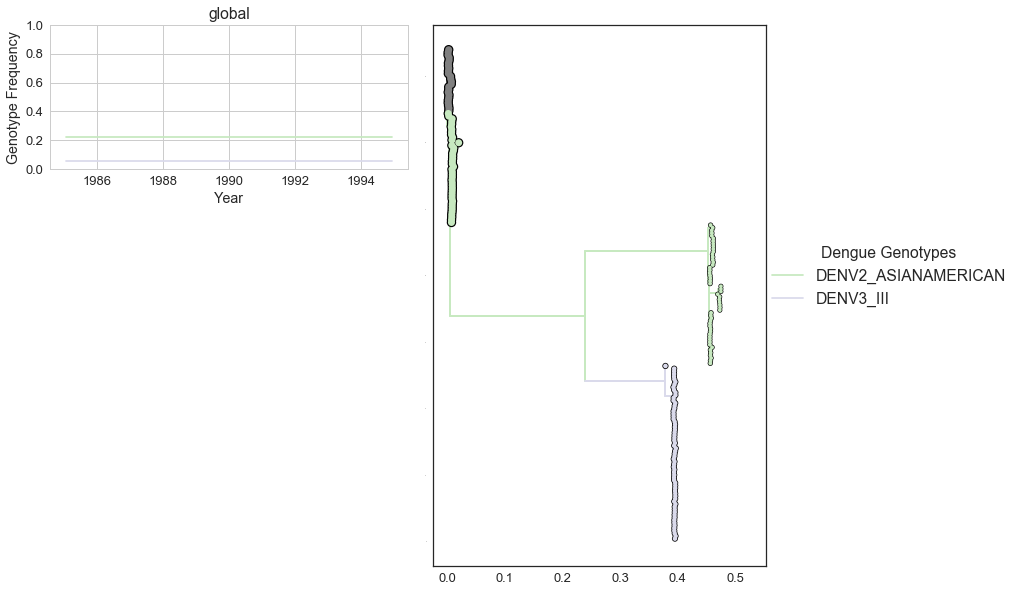

In [11]:
plot_frequencies_and_tree()
# pprint({g : m.traits['clade'] for g,m in mrcas.items()})

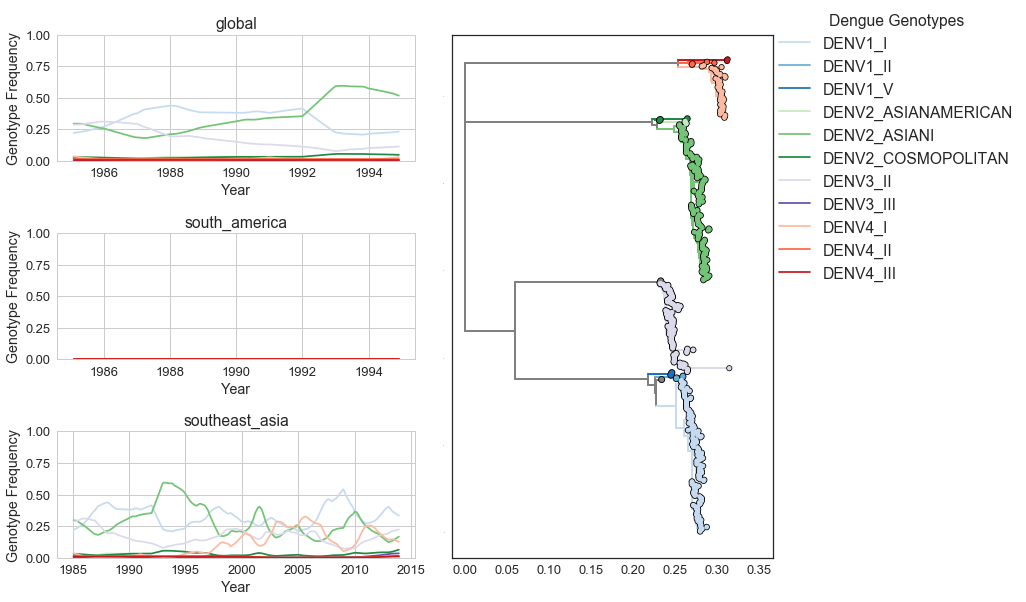

In [31]:
def export(out_path=out_path, dataset_name=dataset_name, tree=tree, region_dfs = region_dfs):
    plot_frequencies_and_tree(save=True, ofilename=out_path+'/'+dataset_name+'_frequencies_tree.png')
    tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
    open(out_path+'/'+dataset_name+'_gtAnnotated_tree.nexus', 'w').write(tree_string)

    if len(region_dfs) == 1:
        region_dfs.values()[0].to_csv(out_path+'/'+dataset_name+'_frequencies.csv')
    else:
        for region, df in region_dfs.items():
            df.to_csv(out_path+'/'+dataset_name+'_'+region+'_frequencies.csv')

export()
    